/Users/pgmenon/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Press enter to continue
Press enter to continue
Press enter to continue


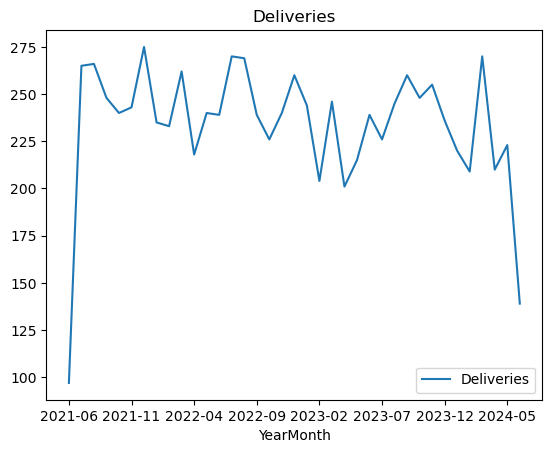

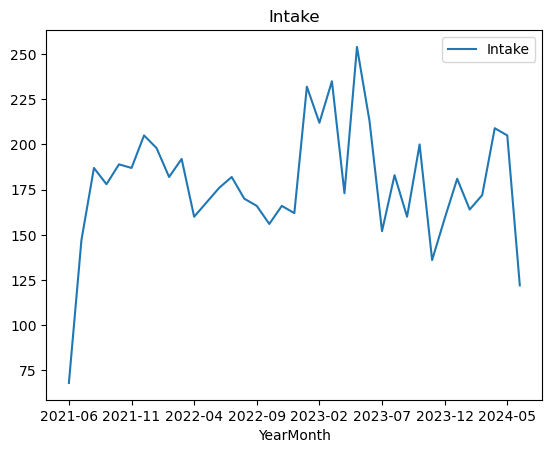

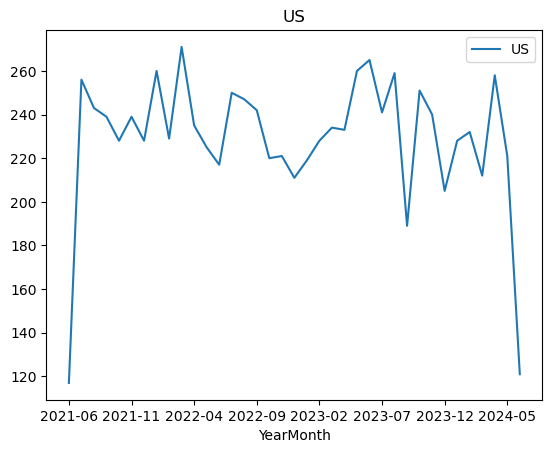

In [1]:
# Read CombinedData.csv and plot each column against the first column which is date / time in YYYY-MM format

import pandas

data = pandas.read_csv('CombinedData.csv')

for column in data.columns:
    if column != 'YearMonth':
        data.plot(x='YearMonth', y=column, title=column)
        print('Press enter to continue')

In [2]:
# Use plotly and superimpose the plots together with a legend
import plotly.express as px

fig = px.line(data, x='YearMonth', y=data.columns[1:], title='All columns')
fig.show()

Model score: 0.40525709849101643
Predicted deliveries: [155.49415314]
Actual deliveries: 139


/Users/pgmenon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



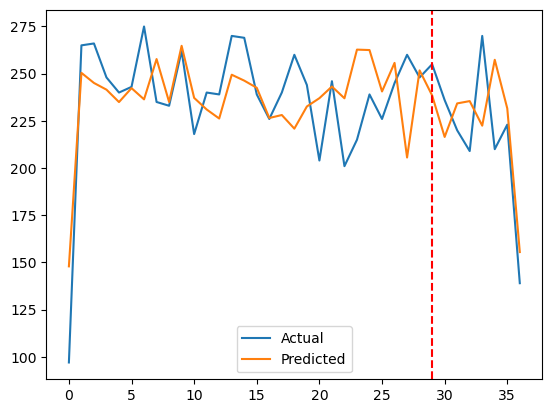

In [12]:
# Build a regression model to predict Deliveries based on the other columns, ignoring date / time
from sklearn.model_selection import train_test_split

X = data.drop(columns=['YearMonth', 'Deliveries'])
y = data['Deliveries']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Replace the random split so that train is the first 80% of the data and test is the remainder 
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

print('Model score:', model.score(X_test, y_test))

# Predict the Deliveries for the last row in the data
print('Predicted deliveries:', model.predict([X.iloc[-1]]))
print('Actual deliveries:', y.iloc[-1])

# Plot the actual deliveries against the predicted deliveries
import matplotlib.pyplot as plt

plt.plot(y, label='Actual')
plt.plot(model.predict(X), label='Predicted')
# add a vertical line to demarcate the training and test data
plt.axvline(x=split, color='r', linestyle='--')
plt.legend()
plt.show()

# Use historical values of each variable (including the target variable) as predictors of the current value of the target variable.

In [4]:
data.head()

,YearMonth,Deliveries,Intake,US
0,2021-06,97,68,117
1,2021-07,265,147,256
2,2021-08,266,187,243
3,2021-09,248,178,239
4,2021-10,240,189,228


In [7]:
# Create an enhanced dataset with the "lagged" signals as new columns, going back to two lags
df_lagged = data.copy()
df_lagged['Deliveries_lag_1'] = df_lagged['Deliveries'].shift(1)
df_lagged['Deliveries_lag_2'] = df_lagged['Deliveries'].shift(2)

df_lagged['Intake_lag_1'] = df_lagged['Intake'].shift(1)
df_lagged['Intake_lag_2'] = df_lagged['Intake'].shift(2)

df_lagged['US_lag_1'] = df_lagged['US'].shift(1)
df_lagged['US_lag_2'] = df_lagged['US'].shift(2)


df_lagged = df_lagged.dropna()
df_lagged.head()


,YearMonth,Deliveries,Intake,US,Deliveries_lag_1,Deliveries_lag_2,Intake_lag_1,Intake_lag_2,US_lag_1,US_lag_2
2,2021-08,266,187,243,265.0,97.0,147.0,68.0,256.0,117.0
3,2021-09,248,178,239,266.0,265.0,187.0,147.0,243.0,256.0
4,2021-10,240,189,228,248.0,266.0,178.0,187.0,239.0,243.0
5,2021-11,243,187,239,240.0,248.0,189.0,178.0,228.0,239.0
6,2021-12,275,205,228,243.0,240.0,187.0,189.0,239.0,228.0


Model score: -0.4750738089009465
Predicted deliveries: [236.56495676]
Actual deliveries: 139


/Users/pgmenon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



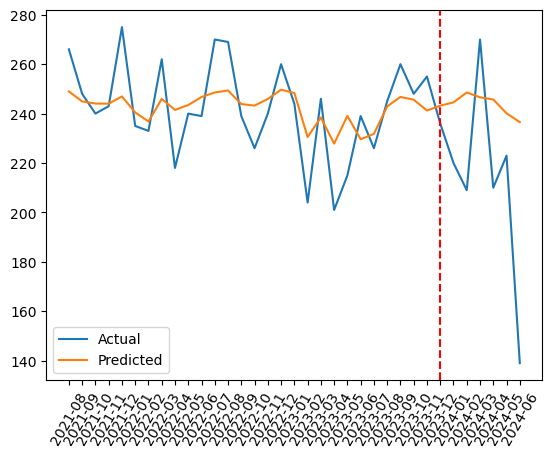

In [30]:
# Build a regression model to predict Deliveries based on the other columns, ignoring date / time
from sklearn.model_selection import train_test_split

X = df_lagged.drop(columns=['YearMonth', 'Deliveries'])
y = df_lagged['Deliveries']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Replace the random split so that train is the first 80% of the data and test is the remainder 
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(X_train, y_train)

# Replace linear regression with a more complex model
from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor() Update this to have only stumps 
model = RandomForestRegressor(max_depth=1)
model.fit(X_train, y_train)

print('Model score:', model.score(X_test, y_test))

# Predict the Deliveries for the last row in the data
print('Predicted deliveries:', model.predict([X.iloc[-1]]))
print('Actual deliveries:', y.iloc[-1])

# Plot the actual deliveries against the predicted deliveries
import matplotlib.pyplot as plt

# plt.plot(y, label='Actual')
# plt.plot(model.predict(X), label='Predicted')
# update the plot command to include the time axis 
plt.plot(df_lagged['YearMonth'], y, label='Actual')
# rotate the labels on the x-axis to make them more readable
plt.xticks(rotation=60)
plt.plot(df_lagged['YearMonth'], model.predict(X), label='Predicted')

# add a vertical line to demarcate the training and test data
plt.axvline(x=split, color='r', linestyle='--')
plt.legend()
plt.show()

# Using autoregressive univariate modeling for Deliveries

In [33]:
import pandas as pd

monthly_deliveries = data.copy()

# Combine deliveries and appointments data
combined_df = monthly_deliveries.set_index('YearMonth') #.join(monthly_appointments, how='left').fillna(0)
combined_df.index = pd.PeriodIndex(combined_df.index, freq='M')

combined_df

,Deliveries,Intake,US
YearMonth,,,
2021-06,97,68,117
2021-07,265,147,256
2021-08,266,187,243
2021-09,248,178,239
2021-10,240,189,228
2021-11,243,187,239
2021-12,275,205,228
2022-01,235,198,260
2022-02,233,182,229


In [36]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
import numpy as np

# Holt-Winters Exponential Smoothing
holt_winters_model = ExponentialSmoothing(combined_df['Deliveries'][:-6], 
                                          trend='add', 
                                          seasonal='add', 
                                          seasonal_periods=12).fit()
holt_winters_forecast = holt_winters_model.forecast(12)
print("Holt-Winters Forecast:")
print(holt_winters_forecast)

# ARIMA Model
arima_model = ARIMA(combined_df['Deliveries'][:-6], order=(1, 1, 1)).fit()
arima_forecast = arima_model.forecast(steps=12)
print("ARIMA Forecast:")
print(arima_forecast)

Holt-Winters Forecast:
2024-01    242.870066
2024-02    221.884945
2024-03    257.399303
2024-04    212.913503
2024-05    230.927941
2024-06    195.992909
2024-07    258.082796
2024-08    264.420253
2024-09    253.462147
2024-10    242.445492
2024-11    250.399458
2024-12    261.303659
Freq: M, dtype: float64
ARIMA Forecast:
2024-01    238.606102
2024-02    238.445759
2024-03    238.455624
2024-04    238.455017
2024-05    238.455055
2024-06    238.455052
2024-07    238.455053
2024-08    238.455053
2024-09    238.455053
2024-10    238.455053
2024-11    238.455053
2024-12    238.455053
Freq: M, Name: predicted_mean, dtype: float64


In [49]:
# Lets use plotly to superimpose the forecasts on the actual data. remember combined_df.index are dates in YYYY-MM format
import plotly.graph_objects as go

# Plot the results using Plotly
fig = go.Figure()

# Add traces for actual data
fig.add_trace(go.Scatter(x=data.index[:-6], y=data['Deliveries'][:-6], mode='lines', name='Train Data'))

fig.add_trace(go.Scatter(x=data.index[-6:], y=holt_winters_forecast, mode='lines', name='Holt-Winters Forecast'))
fig.add_trace(go.Scatter(x=data.index[-6:], y=arima_forecast, fill=None, mode='lines', line_color='green', name='ARIMA Forecast'))
fig.add_trace(go.Scatter(x=data.index[-6:], y=data['Deliveries'][-6:], fill=None, mode='lines', line_color='black', name='ACTUAL'))


fig.show()

In [58]:
""" put this into a single data frame

fig.add_trace(go.Scatter(x=data.index[-6:], y=holt_winters_forecast, mode='lines', name='Holt-Winters Forecast'))
fig.add_trace(go.Scatter(x=data.index[-6:], y=arima_forecast, fill=None, mode='lines', line_color='green', name='ARIMA Forecast'))
fig.add_trace(go.Scatter(x=data.index[-6:], y=data['Deliveries'][-6:], fill=None, mode='lines', line_color='black', name='ACTUAL'))

"""
# Augent data['Deliveries'][-6:] with 6 months of NaNs to match the forecasted data
actuals = np.concatenate([data['Deliveries'][-6:], np.array([np.nan] * 6)])
forecasts_df = pd.DataFrame({'Holt-Winters Forecast': holt_winters_forecast, 'ARIMA Forecast': arima_forecast, 'Actual': actuals})
forecasts_df.index = pd.date_range(start='2024-01-01', periods=12, freq='ME')
forecasts_df

,Holt-Winters Forecast,ARIMA Forecast,Actual
2024-01-31,242.870066,238.606102,220.0
2024-02-29,221.884945,238.445759,209.0
2024-03-31,257.399303,238.455624,270.0
2024-04-30,212.913503,238.455017,210.0
2024-05-31,230.927941,238.455055,223.0
2024-06-30,195.992909,238.455052,139.0
2024-07-31,258.082796,238.455053,NaN
2024-08-31,264.420253,238.455053,NaN
2024-09-30,253.462147,238.455053,NaN
2024-10-31,242.445492,238.455053,NaN


In [59]:
# forecasts_df['ActualUp'] = 1 if forecasts_df['Actual'] > forecasts_df['Actual'].shift(1) else 0
forecasts_df['ActualUp'] = forecasts_df['Actual'] > forecasts_df['Actual'].shift(1)
# If up , make it +1, else -1 
forecasts_df['ActualUp'] = forecasts_df['ActualUp'].apply(lambda x: 1 if x else -1)
# if Actual is NaN, then ActualUp is NaN
forecasts_df['ActualUp'] = forecasts_df['ActualUp'].where(~forecasts_df['Actual'].isna(), np.nan)

forecasts_df['Holt-WintersUp'] = forecasts_df['Holt-Winters Forecast'] > forecasts_df['Holt-Winters Forecast'].shift(1)
forecasts_df['Holt-WintersUp'] = forecasts_df['Holt-WintersUp'].apply(lambda x: 1 if x else -1)
forecasts_df['Holt-WintersUp'] = forecasts_df['Holt-WintersUp'].where(~forecasts_df['Holt-Winters Forecast'].isna(), np.nan)

forecasts_df

,Holt-Winters Forecast,ARIMA Forecast,Actual,ActualUp,Holt-WintersUp
2024-01-31,242.870066,238.606102,220.0,-1.0,-1
2024-02-29,221.884945,238.445759,209.0,-1.0,-1
2024-03-31,257.399303,238.455624,270.0,1.0,1
2024-04-30,212.913503,238.455017,210.0,-1.0,-1
2024-05-31,230.927941,238.455055,223.0,1.0,1
2024-06-30,195.992909,238.455052,139.0,-1.0,-1
2024-07-31,258.082796,238.455053,NaN,NaN,1
2024-08-31,264.420253,238.455053,NaN,NaN,1
2024-09-30,253.462147,238.455053,NaN,NaN,-1
2024-10-31,242.445492,238.455053,NaN,NaN,-1


In [60]:
# Cross tab of the actual and forecasted directions
pd.crosstab(forecasts_df['ActualUp'], forecasts_df['Holt-WintersUp'])

Holt-WintersUp,-1,1
ActualUp,,
-1.0,4,0
1.0,0,2
